# **OpenFoodFact**

# A. IMPORT


In [ ]:
import pandas as pd, seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import joblib
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import scatter_matrix
pd.set_option('max_colwidth', 20000)
import re
from sklearn import preprocessing, neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.model_selection import cross_val_score, KFold, RepeatedStratifiedKFold, StratifiedKFold
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, make_scorer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_nova = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Saved_dataset/df_nova.csv") 

#**B. Classification**

##1. Visualize the distribution of the label

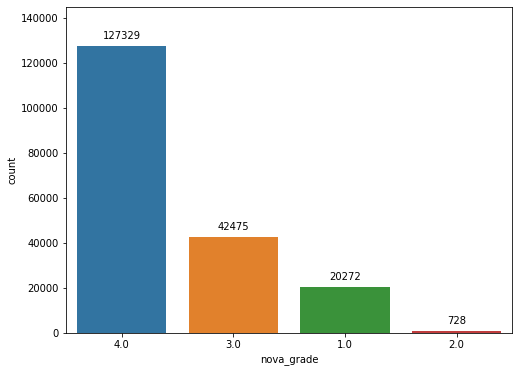

In [ ]:
nova_count = df_nova['nova_grade'].value_counts().reset_index()
nova_count = nova_count.rename(columns={'index':'nova_grade','nova_grade':'count'})
nova_count.sort_values('count',ascending=False,inplace=True)

plt.figure(figsize=(8,6))
plt.subplot()
nplot = sns.barplot(data=nova_count, x='nova_grade',y='count',order=nova_count['nova_grade'].values)

for p in nplot.patches:
  nplot.annotate(format(p.get_height(), '.0f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()+10000),
                 ha = 'center', va='center',
                 xytext=(0,-12),
                textcoords = 'offset points')
plt.ylim(top=145000)
plt.show()

Due to the imbalanced nature of the target, SMOTE method which is an Over-sampling approach that creates synthetic minority class samples will be implemented in the pipeline

##Split data

In [ ]:
X = df_nova.drop(columns=['nova_grade'])
y = df_nova['nova_grade']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(152643, 11) (152643,)
(38161, 11) (38161,)


In [ ]:
def get_samples(n_samples, X, y=None):
  """Get n_samples randomly from dataset"""
  np.random.seed(42)
  samples_index = np.random.choice(np.arange(len(X)), n_samples, replace=False)
  if not y is None:
    return X.iloc[samples_index], y.iloc[samples_index]  
  return X.iloc[samples_index]

# Get a smaller sample size for faster training
n_samples = 50000
X_train_sample, y_train_sample = get_samples(n_samples, X_train, y_train)

## Baseline model

###Dummy Classifier

DummyClassifier is a classifier model that makes predictions without trying to find patterns in the data

              precision    recall  f1-score   support

         1.0      0.103     0.254     0.146      4835
         2.0      0.010     0.252     0.019       468
         3.0      0.212     0.251     0.230     10176
         4.0      0.678     0.249     0.364     32351

    accuracy                          0.250     47830
   macro avg      0.251     0.251     0.190     47830
weighted avg      0.514     0.250     0.310     47830



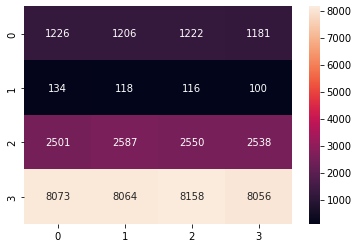

In [ ]:
pipe_dum = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',DummyClassifier(strategy='stratified'))
                    ])

pipe_dum.fit(X_train, y_train)

y_pred = pipe_dum.predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
print("Acc:", accuracy_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, pipe_dum.predict_proba(X_test), multi_class='ovo'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))
print("Fbeta:", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.24984319464771065
ROC_AUC: 0.5007015396264499
F1: 0.3102046366584849
Fbeta: 0.21292835836162838


##Benchmark (Cross-val)

In [ ]:
models_dict = {"Dummy Classifier": DummyClassifier(),
            "Logistic Regression": LogisticRegression(),
            "DecisionTreeClassifier": DecisionTreeClassifier(),
            "RandomForestClassifier": RandomForestClassifier(),
            "LGBMClassifier": LGBMClassifier()
  }
fbeta = make_scorer(fbeta_score, beta=0.5, average='weighted')
roc_auc = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

metrics = {"Accuracy": "accuracy",
           "F1_weighted": "f1_weighted",
           "Fbeta": fbeta,
           "ROC_AUC": roc_auc}
           
cv = KFold(n_splits=5, shuffle=True, random_state=42)           

In [ ]:
# Benchmark cross-validation scores for training data of 180K
for model_name, model in models_dict.items():
  print(model_name + ":")
  for metric_name, metric in metrics.items():
    pipe = Pipeline([('smt', SMOTE(random_state=42)),  
                    ('scaler',StandardScaler()),
                    (model_name, model)])
    
    score = np.mean(cross_val_score(pipe, X_train, y_train, cv=cv, scoring= metric))
    print("\t" + metric_name + f": {score}")
  # print("\n")

Dummy Classifier:
	Accuracy: 0.25023232191811673
	F1_weighted: 0.3112457917310036
	Fbeta: 0.40191470351984576
	ROC_AUC: 0.49846583094545077
Logistic Regression:
	Accuracy: 0.7312270891754594
	F1_weighted: 0.7571801586580211
	Fbeta: 0.7862144622676099
	ROC_AUC: 0.9258979482625188
DecisionTreeClassifier:
	Accuracy: 0.8751880589481992
	F1_weighted: 0.8763441894478484
	Fbeta: 0.8770437083875942
	ROC_AUC: 0.8977670939575116
RandomForestClassifier:
	Accuracy: 0.9064228618406934
	F1_weighted: 0.9071816827686838
	Fbeta: 0.907563489439349
	ROC_AUC: 0.9788602657577117
LGBMClassifier:
	Accuracy: 0.8519624852750661
	F1_weighted: 0.8558707846898372
	Fbeta: 0.8606213346182308
	ROC_AUC: 0.9735314377417719


In [ ]:
#put in df
fbeta = make_scorer(fbeta_score, beta=0.5, average='weighted')
roc_auc = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)

def baseline_report_cv_(model, X_train, y_train, n_splits, name):
  cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)   

  accuracy     = np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring='accuracy'))
  f1_weighted      = np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring='f1_weighted'))
  fbeta_score  = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring= fbeta))
  rocauc       = np.mean(cross_val_score(model, X_train, y_train,cv=cv, scoring=roc_auc))

  scores_df = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'f1_weighted'      : [f1_weighted],
                             'fbeta'        : [fbeta_score],
                             'rocauc'       : [rocauc]})
  return scores_df

In [ ]:
pipe_dum = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',DummyClassifier(strategy='stratified'))
                    ])
pipe_lr = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',LogisticRegression())
                    ])
pipe_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier())])
pipe_dtc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',DecisionTreeClassifier())])
pipe_lgbm = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',LGBMClassifier())
                    ])

In [ ]:
scores_df = pd.concat([baseline_report_cv_(pipe_dum, X_train, y_train, 5, 'DummyClassifier'),
                       baseline_report_cv_(pipe_lr, X_train, y_train, 5, 'LogisticRegression'),
                       baseline_report_cv_(pipe_rfc, X_train, y_train, 5, 'DecisionTreeClassifier'),
                       baseline_report_cv_(pipe_dtc, X_train, y_train, 5, 'RandomForestClassifier'),
                       baseline_report_cv_(pipe_lgbm, X_train, y_train, 5, 'LGBMClassifier')
                       ], axis=0).reset_index()

In [ ]:
scores = scores_df.drop("index", axis=1)
scores.index +=1
scores

,model,accuracy,f1_weighted,fbeta,rocauc
1,DummyClassifier,0.250607,0.311207,0.398239,0.503446
2,LogisticRegression,0.722981,0.751057,0.781360,0.920968
3,DecisionTreeClassifier,0.904365,0.905091,0.905551,0.976237
4,RandomForestClassifier,0.872408,0.873689,0.874652,0.894013
5,LGBMClassifier,0.849421,0.853567,0.858507,0.971897


In [ ]:
scores.to_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/Dataset/nova_benchmark_df.csv", index=False)

In [ ]:
scores = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/nova_benchmark_df.csv")

**Comment:** Random Forest Classifier has the highest scores for all metrics and will be fine-tuned for the Final Model 

##Benchmark

####Logistic Regression

              precision    recall  f1-score   support

         1.0      0.575     0.871     0.693      4835
         2.0      0.136     0.895     0.236       468
         3.0      0.491     0.566     0.525     10176
         4.0      0.949     0.754     0.840     32351

    accuracy                          0.727     47830
   macro avg      0.538     0.771     0.574     47830
weighted avg      0.806     0.727     0.752     47830



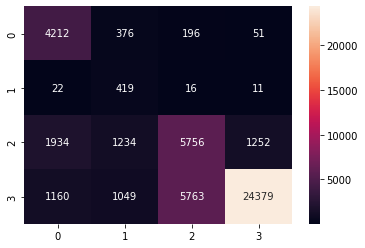

In [ ]:
pipe_lr = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',LogisticRegression())
                    ])

pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")

In [ ]:
print("Acc:", accuracy_score(y_test, y_pred))
print("ROC_AUC:", roc_auc_score(y_test, pipe_lr.predict_proba(X_test), multi_class='ovo'))
print("F1:", f1_score(y_test, y_pred, average='weighted'))
print("Fbeta:", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.7268659836922433
ROC_AUC: 0.9277030239614207
F1: 0.752292089806005
Fbeta: 0.546701322739955


####KNN

              precision    recall  f1-score   support

         1.0      0.815     0.919     0.863      4586
         2.0      0.546     0.893     0.678       422
         3.0      0.686     0.811     0.743      9536
         4.0      0.956     0.875     0.914     30655

    accuracy                          0.866     45199
   macro avg      0.751     0.874     0.800     45199
weighted avg      0.881     0.866     0.870     45199



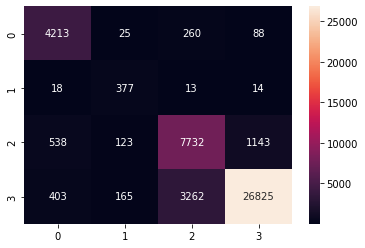

In [ ]:
pipe_knn = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',KNeighborsClassifier())
                    ])

pipe_knn.fit(X_train, y_train)

y_pred = pipe_knn.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_test, pipe_knn.predict_proba(X_test), multi_class='ovo'))
print("F1",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.8661032323723976
ROC_AUC: 0.9494179071109583
F1 0.870385740402514
Fbeta 0.768057568188266


####Random Forest

              precision    recall  f1-score   support

         1.0      0.886     0.926     0.906      4835
         2.0      0.716     0.876     0.788       468
         3.0      0.802     0.815     0.809     10176
         4.0      0.950     0.936     0.943     32351

    accuracy                          0.909     47830
   macro avg      0.838     0.888     0.861     47830
weighted avg      0.910     0.909     0.909     47830



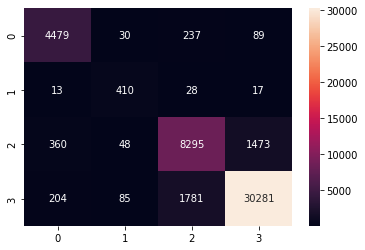

In [ ]:
pipe_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier())])
pipe_rfc.fit(X_train, y_train)

y_pred = pipe_rfc.predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_test, pipe_rfc.predict_proba(X_test), multi_class='ovo'))
print("F1",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.9087392849675936
ROC_AUC: 0.9797257819584487
F1 0.9092286879024433
Fbeta 0.8471695609866265


####SVC

              precision    recall  f1-score   support

         1.0      0.631     0.908     0.744      4586
         2.0      0.218     0.919     0.352       422
         3.0      0.544     0.671     0.600      9536
         4.0      0.954     0.780     0.858     30655

    accuracy                          0.771     45199
   macro avg      0.586     0.819     0.639     45199
weighted avg      0.828     0.771     0.787     45199



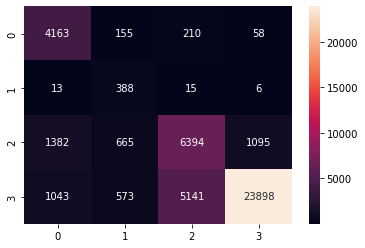

In [ ]:
pipe_svc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',MinMaxScaler()),
                    ('model',SVC())
                    ])

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))
sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("F1:",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta:",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.7708798867231575
F1: 0.7873484485728998
Fbeta: 0.6016978796151916


###LGBMClassifier

              precision    recall  f1-score   support

         1.0      0.781     0.922     0.845      4586
         2.0      0.481     0.915     0.630       422
         3.0      0.668     0.750     0.707      9536
         4.0      0.943     0.870     0.905     30655

    accuracy                          0.850     45199
   macro avg      0.718     0.864     0.772     45199
weighted avg      0.864     0.850     0.855     45199



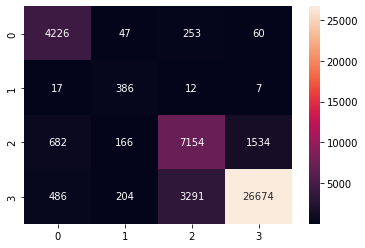

In [ ]:
pipe_lgbm = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',MinMaxScaler()),
                    ('model',LGBMClassifier())
                    ])

pipe_lgbm.fit(X_train, y_train)

y_pred = pipe_lgbm.predict(X_test)

sns.heatmap(data=confusion_matrix(y_test, y_pred), annot=True,fmt = ".0f")
print(classification_report(y_test, y_pred, digits=3))

In [ ]:
print("Acc:",accuracy_score(y_test, y_pred))
print("ROC_AUC:",roc_auc_score(y_test, pipe_lgbm.predict_proba(X_test), multi_class='ovo'))
print("F1",f1_score(y_test, y_pred, average='weighted'))
print("Fbeta",fbeta_score(y_test, y_pred, beta=0.5, average='macro'))

Acc: 0.8504612933914467
ROC_AUC: 0.9738852342890612
F1 0.8547454447946051
Fbeta 0.7368416949123331


###ANN

In [ ]:
# Oversampling
smt = SMOTE(random_state=42)
X_train_transformed, y_train_transformed = smt.fit_resample(X_train, y_train)
X_test_transformed, y_test_transformed = smt.fit_resample(X_test, y_test)

# Normalization
scaler = StandardScaler()
X_train_transformed =  scaler.fit_transform(X_train_transformed)
X_test_transformed =  scaler.transform(X_test_transformed)

y_train_transformed = y_train_transformed -1
y_test_transformed = y_test_transformed -1

In [ ]:
model = tf.keras.Sequential([
          layers.Input(shape=(11,)),
          layers.Dense(512, activation='relu'),
          layers.Dense(256, activation='relu'),
          layers.Dense(128, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(16, activation='relu'),
          layers.Dropout(0.2),
          layers.Dense(4, activation='softmax')
          ])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train_transformed, epochs=20, validation_data=(X_test_transformed, y_test_transformed))

Epoch 1/20
13411/13411 [==============================] - 66s 5ms/step - loss: 0.4320 - accuracy: 0.8444 - val_loss: 0.3991 - val_accuracy: 0.8571
Epoch 2/20
13411/13411 [==============================] - 59s 4ms/step - loss: 0.3568 - accuracy: 0.8704 - val_loss: 0.4025 - val_accuracy: 0.8674
Epoch 3/20
13411/13411 [==============================] - 61s 5ms/step - loss: 0.3277 - accuracy: 0.8806 - val_loss: 0.4313 - val_accuracy: 0.8676
Epoch 4/20
13411/13411 [==============================] - 55s 4ms/step - loss: 0.3111 - accuracy: 0.8863 - val_loss: 0.4581 - val_accuracy: 0.8698
Epoch 5/20
13411/13411 [==============================] - 57s 4ms/step - loss: 0.3001 - accuracy: 0.8905 - val_loss: 0.4670 - val_accuracy: 0.8726
Epoch 6/20
13411/13411 [==============================] - 59s 4ms/step - loss: 0.2897 - accuracy: 0.8939 - val_loss: 0.4417 - val_accuracy: 0.8748
Epoch 7/20
13411/13411 [==============================] - 66s 5ms/step - loss: 0.2822 - accuracy: 0.8965 - val_loss: 0

In [ ]:
model = tf.keras.Sequential([
          layers.Input(shape=(11,)),
          layers.Dense(16, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(64, activation='relu'),
          layers.Dense(128, activation='relu'),
          
          layers.Dropout(0.2),
          layers.Dense(4, activation='softmax')
          ])

model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_transformed, y_train_transformed, epochs=20, validation_data=(X_test_transformed, y_test_transformed))

Epoch 1/20
15328/15328 [==============================] - 30s 2ms/step - loss: 0.4246 - accuracy: 0.8406 - val_loss: 0.3996 - val_accuracy: 0.8509
Epoch 2/20
15328/15328 [==============================] - 28s 2ms/step - loss: 0.3683 - accuracy: 0.8612 - val_loss: 0.3834 - val_accuracy: 0.8617
Epoch 3/20
15328/15328 [==============================] - 30s 2ms/step - loss: 0.3511 - accuracy: 0.8669 - val_loss: 0.3817 - val_accuracy: 0.8645
Epoch 4/20
15328/15328 [==============================] - 28s 2ms/step - loss: 0.3400 - accuracy: 0.8716 - val_loss: 0.3892 - val_accuracy: 0.8671
Epoch 5/20
15328/15328 [==============================] - 27s 2ms/step - loss: 0.3332 - accuracy: 0.8742 - val_loss: 0.3987 - val_accuracy: 0.8626
Epoch 6/20
15328/15328 [==============================] - 28s 2ms/step - loss: 0.3267 - accuracy: 0.8767 - val_loss: 0.4058 - val_accuracy: 0.8651
Epoch 7/20
15328/15328 [==============================] - 27s 2ms/step - loss: 0.3226 - accuracy: 0.8783 - val_loss: 0

##Fine-tuning Best Model

In [ ]:
param_grid = [
    {'model__n_estimators': [2, 5, 10, 15, 20, 30, 40], 
     'model__max_features': [2, 4, 6, 8]}
  ]

pipe_rfc = Pipeline([('smt', SMOTE(random_state=42)),
                    ('scaler',StandardScaler()),
                    ('model',RandomForestClassifier())])

cv=KFold(n_splits=5, random_state=42, shuffle=True)
rfc_gs = GridSearchCV(pipe_rfc, param_grid, cv=cv,
                           scoring='accuracy',
                           return_train_score=True, n_jobs=-1, verbose=2)

rfc_gs.fit(X_train, y_train)

rfc_result = pd.DataFrame(rfc_gs.cv_results_)
rfc_result = rfc_result.sort_values('rank_test_score')
for rec in rfc_result[['params','mean_test_score','std_test_score','rank_test_score']].values[:5]:
    print('-'*10)
    print(f'Rank {rec[-1]}')
    print(f'Params: {rec[0]}')
    print(f'Mean Accuracy:{rec[1]:.3f} +- {rec[2]:.3f}')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed: 32.5min finished


----------
Rank 1
Params: {'model__max_features': 2, 'model__n_estimators': 40}
Mean Accuracy:0.903 +- 0.001
----------
Rank 2
Params: {'model__max_features': 4, 'model__n_estimators': 40}
Mean Accuracy:0.903 +- 0.001
----------
Rank 3
Params: {'model__max_features': 2, 'model__n_estimators': 30}
Mean Accuracy:0.902 +- 0.001
----------
Rank 4
Params: {'model__max_features': 6, 'model__n_estimators': 40}
Mean Accuracy:0.902 +- 0.000
----------
Rank 5
Params: {'model__max_features': 4, 'model__n_estimators': 30}
Mean Accuracy:0.902 +- 0.001


The highest Accuracy Random Forest Classifier model can achieve is 0.903. I will choose params (max_features:4, n_estimators:40) as the final model

##Final Evaluation on Test set

In [ ]:
# retrieve the best RF model
best_rfc = rfc_gs.best_estimator_

# test the final model on Validation set
y_pred = best_rfc.predict(X_test)

# print(f"Random Forest Classifier {rfc_gs.best_params_}\n")
# Accuracy
final_acc = accuracy_score(y_test, y_pred)
print("Accuracy:", final_acc)

# F1_weighted
final_f1 = f1_score(y_test, y_pred, average='weighted')
print("\nF1_weighted:", final_f1)

# Fbeta
fbeta = make_scorer(fbeta_score, beta=0.5, average='weighted')
final_fbeta = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
print('\nFbeta:', final_fbeta)

# ROC_AUC
roc_auc = make_scorer(roc_auc_score, multi_class='ovo',needs_proba=True)
final_auc = roc_auc_score(y_test, best_rfc.predict_proba(X_test), multi_class='ovo')
print("\nROC_AUC", final_auc)

Accuracy: 0.9079950735043631

F1_weighted: 0.9086927783007587

Fbeta: 0.9093037381345891

ROC_AUC 0.975589662840354


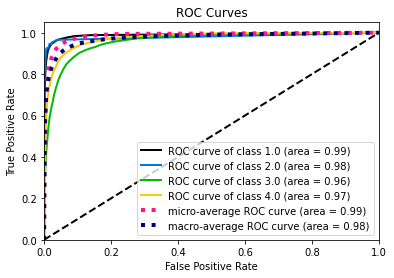

In [ ]:
# !pip install scikit-plot
import scikitplot as skplt

y_pred = best_rfc.predict_proba(X_test) # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_pred)
plt.show()

##Error analysis

              precision    recall  f1-score   support

         1.0      0.888     0.924     0.906      4054
         2.0      0.642     0.822     0.721       146
         3.0      0.800     0.828     0.814      8495
         4.0      0.951     0.932     0.942     25466

    accuracy                          0.908     38161
   macro avg      0.820     0.877     0.846     38161
weighted avg      0.910     0.908     0.909     38161



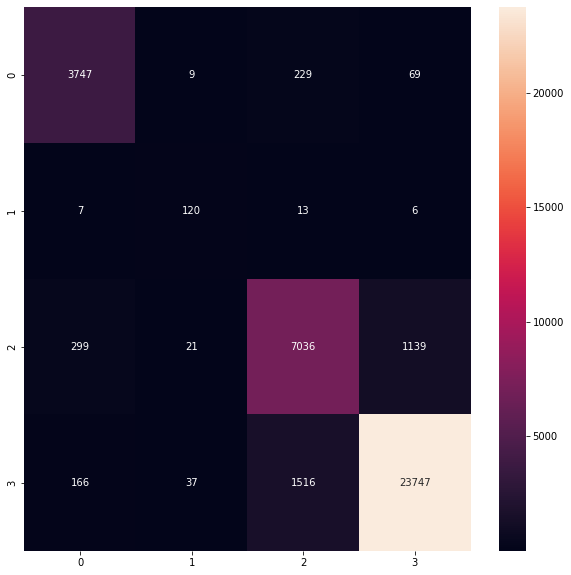

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data=confusion_matrix(y_test, best_rfc.predict(X_test)), annot=True,fmt = ".0f")
print(classification_report(y_test, best_rfc.predict(X_test), digits=3))

##Feature Importance

In [ ]:
feature_importances = best_rfc['model'].feature_importances_
sorted(zip(feature_importances, X_train.columns.values), reverse=True)

[(0.21653401507619702, 'Additives_count'),
 (0.1980431926696242, 'Sodium'),
 (0.14888290538742777, 'Energy_kcal'),
 (0.14413306461354555, 'Fat'),
 (0.06783588018689773, 'Carbohydrates'),
 (0.0624303786348369, 'Sugars'),
 (0.05081216300483267, 'Protein'),
 (0.04491366445022203, 'Saturated fat'),
 (0.0399314312339102, 'Fiber'),
 (0.02354183543392572, 'Cholesterol'),
 (0.0029414693085802433, 'Trans fat')]

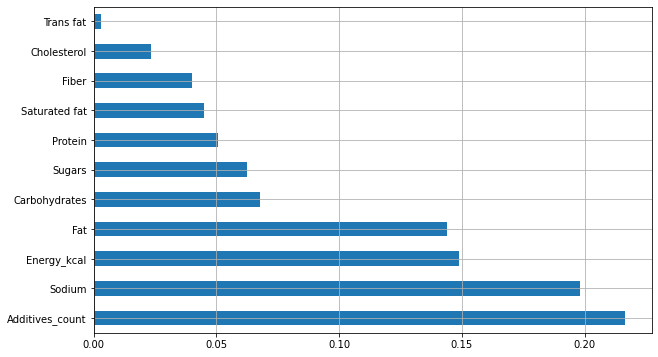

In [ ]:
feat_importances = pd.Series(feature_importances, index=X_train.columns)

plt.figure(figsize=(10,6))
feat_importances.nlargest(20).plot(kind='barh', grid=True)
# plt.savefig("feature_imp.jpg",dpi=300)
plt.show()

**Comment:** Apparently, **Additives** is the most important feature and **Trans fat** doesn't contribute much to the mean decrease in impurity of each tree

##Future deployment

In [ ]:
best_rfc.fit(X, y)

Pipeline(memory=None,
         steps=[('smt',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=4,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min

Save model

In [ ]:
# import joblib

# joblib.dump(best_rfc, "nova_rfc_11.pkl")

# !cp "/content/nova_rfc_11.pkl" "/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files"
# # and later...
best_rfc = joblib.load("/content/gdrive/MyDrive/Colab Notebooks/FINAL PROJECT/Saved_files/nova_rfc.pkl")